In [ ]:
from scipy import signal
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import csv
plt.rcParams['figure.figsize'] = [15, 5] # resize plot area (in inches)


In [ ]:
# low-pass filter parameters based on sampling and cutoff frequencies (fs, fc)
def lpfParams (fc, fs):
    w0 = 2*np.pi*fc;    # cutoff frequency (in rad/s)
    num = w0            # transfer function numerator coefficients
    den = [1,w0]        # transfer function denominator coefficients
    lowPass = signal.TransferFunction(num,den) # transfer function
    dt = 1.0/fs                                # time between samples
    result = lowPass.to_discrete(dt,method='gbt',alpha=0.5) # coefficients in numerator/denominator
    b = result.num  # will become coefficients of current and previous input samples
    a = -result.den # will become coefficients of previous output sample
    return a,b


# high-pass filter parameters based on sampling and cutoff frequencies (fs, fc)
def hpfParams (fc, fs):
    w0 = 2*np.pi*fc;    # cutoff frequency (in rad/s)
    num = [1,0]         # transfer function numerator coefficients
    den = [1,w0]        # transfer function denominator coefficients
    lowPass = signal.TransferFunction(num,den) # transfer function
    dt = 1.0/fs                                # time between samples
    result = lowPass.to_discrete(dt,method='gbt',alpha=0.5) # coefficients in numerator/denominator
    b = result.num  # will become coefficients of current and previous input samples
    a = -result.den # will become coefficients of previous output sample
    return a,b


def applyFilter(x,inputCoeff = [1,0], outputCoeff = [0]):
# Filter the signal using the difference equation
    y = np.zeros(len(x))
    for i in range(2,len(x)):
        y[i] = outputCoeff[0]*y[i-1] + inputCoeff[0]*x[i] + inputCoeff[1]*x[i-1]
    return y




Filter coefficients b_i: [0.13575525 0.13575525]
Filter coefficients a_i: [0.7284895]


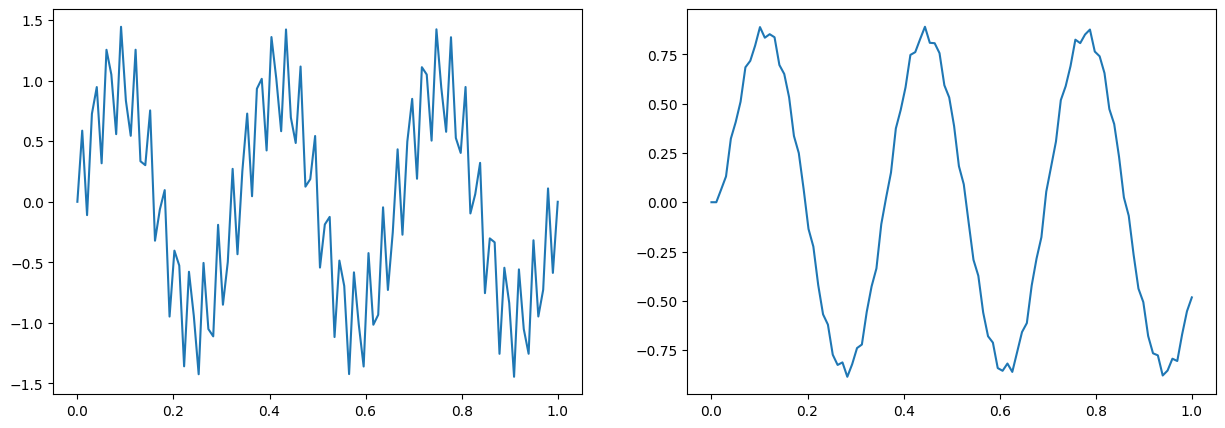

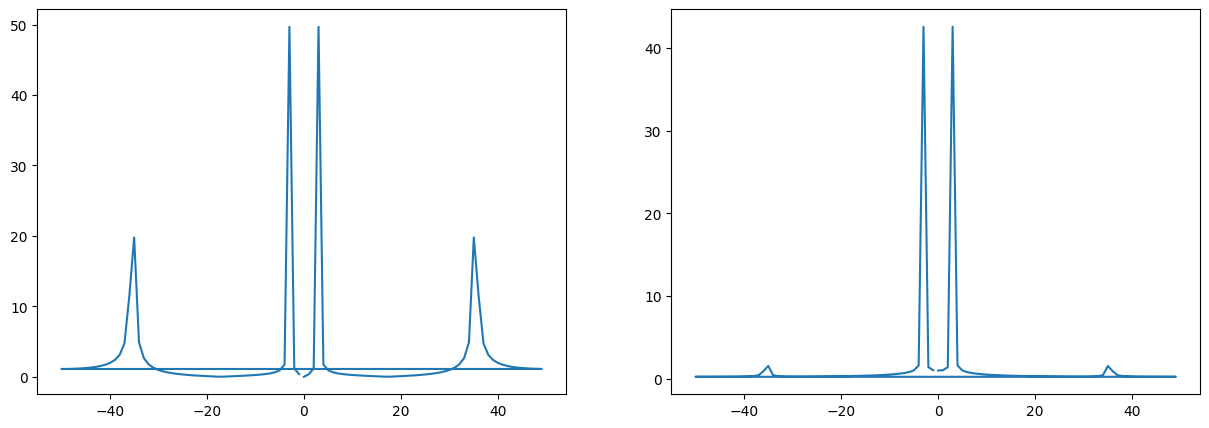

In [ ]:
Fs = 100             # sampling frequency
tlims = [0,1]        # to have 1 second of simulated signal
t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*Fs) # create an array of time divisions based on the above limits
signalFreq = [3,35]                                       # sine wave frequencies in Hz -> cycles / second
signalMag = [1,0.5]                                       # magnitude of each sine wave

# generate the signal based on the above frequencies and amplitudes
x = signalMag[0]*np.sin(2*math.pi*signalFreq[0]*t) + signalMag[1]*np.sin(2*math.pi*signalFreq[1]*t)

# compute the Fourier transform --> transform to frequency domain
xhat = np.fft.fft(x)

# testing lpf
Fc = 5
a,b = lpfParams(Fc,Fs)
a = a[1:]    # ignore a[0] --> not relevant

print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a))

# let y be the low-pass filtered signal
y = applyFilter(x,b,a)
# compute the Fourier transform --> transform to frequency domain
yhat = np.fft.fft(y)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, x)
ax[1].plot(t, y)

fcycles = np.fft.fftfreq(len(t),d=1.0/Fs); # the frequencies in cycles/s

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(fcycles,np.absolute(xhat))
ax[1].plot(fcycles,np.absolute(yhat))

mean:  1.0499698351264843
Filter coefficients b_i: [ 0.96954097 -0.96954097]
Filter coefficients a_i: [0.93908194]
Filter coefficients b_i: [0.11163521 0.11163521]
Filter coefficients a_i: [0.77672958]


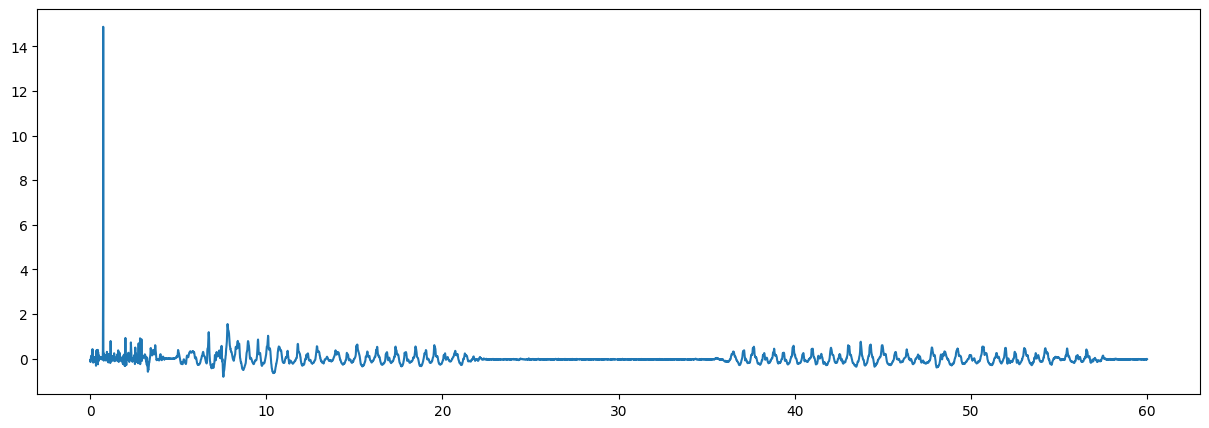

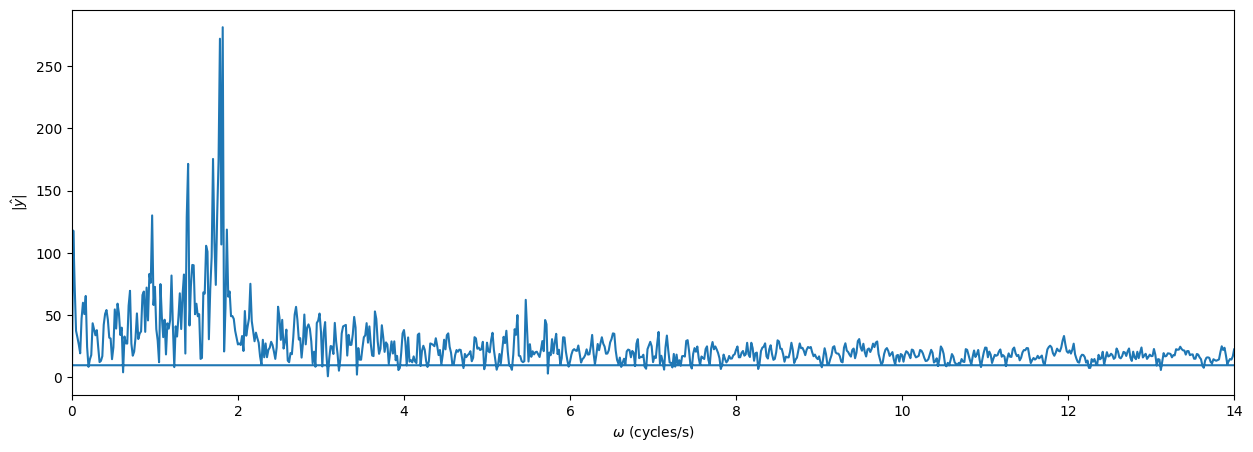

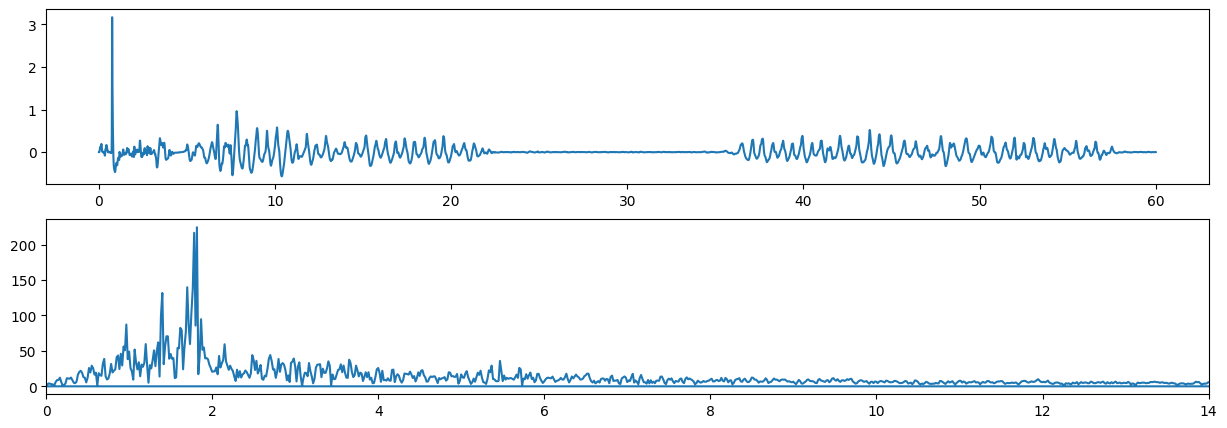

In [ ]:
NSAMPLES=50000
rows = []
with open("values.csv",'r',newline='') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        rows.append(row)

strings_x = list(pd.DataFrame(rows)[0])
strings_y = list(pd.DataFrame(rows)[1])
strings_z = list(pd.DataFrame(rows)[2])

values = [[eval(strings_x[i]),eval(strings_y[i]),eval(strings_z[i])] for i in range(len(strings_x))]
magnitudes = [np.linalg.norm(values[i]) for i in range(len(strings_z))]

acc_x = [values[i][0]for i in range(len(strings_z))]
acc_y = [values[i][1]for i in range(len(strings_z))]
acc_z = [values[i][2]for i in range(len(strings_z))]


print("mean: ", np.mean(magnitudes))

# Compute the Fourier transform of one time series
y = magnitudes-np.mean(magnitudes)
samplingFreq = 100
yhat = np.fft.fft(y)
fcycles = np.fft.fftfreq(len(magnitudes),d=1.0/samplingFreq) # the frequencies in cycles/s
t = [i / samplingFreq for i in range(NSAMPLES)]

# Plot the signal
plt.figure()
plt.plot(t[:len(y)],y)#[len(t)-1500:len(t)]

# Plot the power spectrum
plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.xlim([0,14]);
#plt.ylim([0,15000])
plt.xlabel("$\omega$ (cycles/s)");
plt.ylabel("$|\hat{y}|$");








#HPF
Fc = 1
a,b = hpfParams(Fc,Fs)
a = a[1:]    # ignore a[0] --> not relevant

print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a))

# let y now be the high-pass filtered signal
yhpf = applyFilter(y,b,a)


#LPF
Fc = 4

a,b = lpfParams(Fc,Fs)
a = a[1:]    # ignore a[0] --> not relevant

print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a))

# let y be the low-pass filtered signal
ylpf = applyFilter(yhpf,b,a)
# compute the Fourier transform --> transform to frequency domain
yhat = np.fft.fft(ylpf)

fcycles = np.fft.fftfreq(len(y),d=1.0/samplingFreq) # the frequencies in cycles/s
t = [i / samplingFreq for i in range(NSAMPLES)]

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(t[:len(ylpf)], ylpf)
ax[1].plot(fcycles, np.absolute(yhat))
plt.xlim([0,14]);

Filter coefficients b_i: [ 0.97250312 -0.97250312]
Filter coefficients a_i: [0.94500624]
Filter coefficients b_i: [0.10160597 0.10160597]
Filter coefficients a_i: [0.79678806]


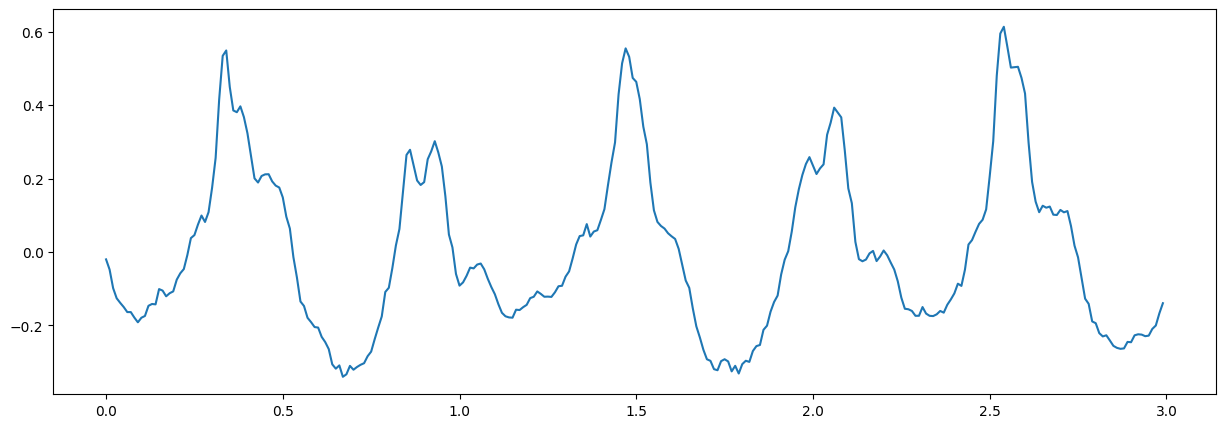

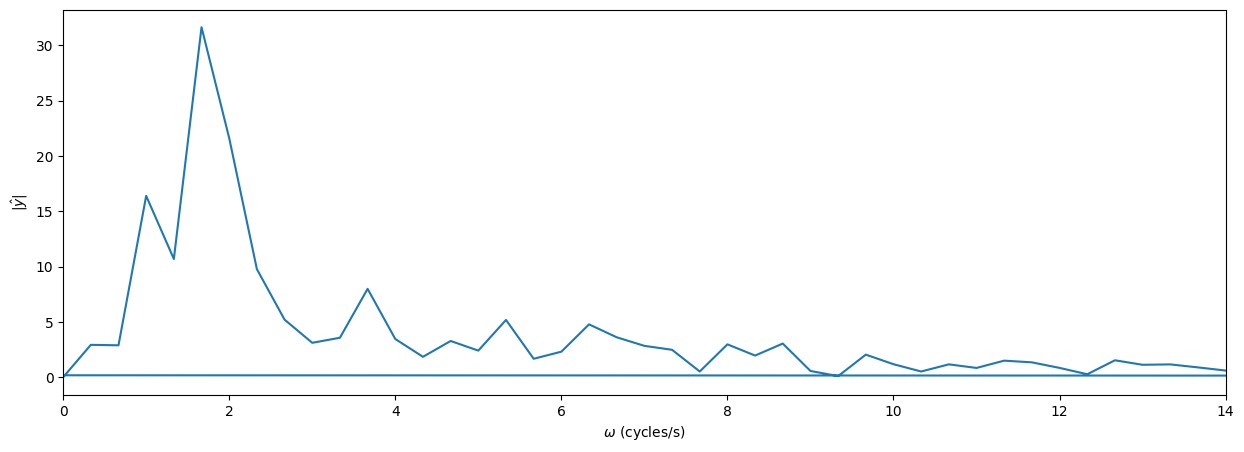

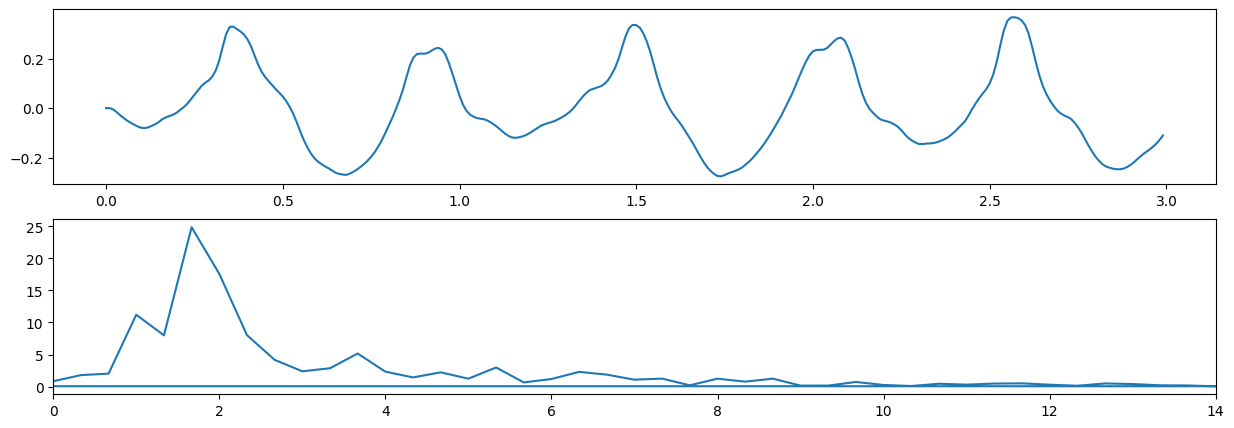

In [ ]:


NSAMPLES=50000
rows = []
with open("values.csv",'r',newline='') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        rows.append(row)

rows = rows[1700:2000]

strings_x = list(pd.DataFrame(rows)[0])
strings_y = list(pd.DataFrame(rows)[1])
strings_z = list(pd.DataFrame(rows)[2])

values = [[eval(strings_x[i]),eval(strings_y[i]),eval(strings_z[i])] for i in range(len(strings_x))]
magnitudes = [np.linalg.norm(values[i]) for i in range(len(strings_z))]

acc_x = [values[i][0]for i in range(len(strings_z))]
acc_y = [values[i][1]for i in range(len(strings_z))]
acc_z = [values[i][2]for i in range(len(strings_z))]

# Compute the Fourier transform of one time series
y = magnitudes-np.mean(magnitudes)
samplingFreq = 100
yhat = np.fft.fft(y)
fcycles = np.fft.fftfreq(len(magnitudes),d=1.0/samplingFreq) # the frequencies in cycles/s
t = [i / samplingFreq for i in range(NSAMPLES)]

# Plot the signal
plt.figure()
plt.plot(t[:len(y)],y)#[len(t)-1500:len(t)]

# Plot the power spectrum
plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.xlim([0,14]);
#plt.ylim([0,15000])
plt.xlabel("$\omega$ (cycles/s)");
plt.ylabel("$|\hat{y}|$");








#HPF
Fc = 0.9
a,b = hpfParams(Fc,Fs)
a = a[1:]    # ignore a[0] --> not relevant

print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a))

# let y now be the high-pass filtered signal
yhpf = applyFilter(y,b,a)


#LPF
Fc = 3.6


a,b = lpfParams(Fc,Fs)
a = a[1:]    # ignore a[0] --> not relevant

print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a))

# let y be the low-pass filtered signal
ylpf = applyFilter(yhpf,b,a)
# compute the Fourier transform --> transform to frequency domain
yhat = np.fft.fft(ylpf)

fcycles = np.fft.fftfreq(len(y),d=1.0/samplingFreq) # the frequencies in cycles/s
t = [i / samplingFreq for i in range(NSAMPLES)]

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(t[:len(ylpf)], ylpf)
ax[1].plot(fcycles, np.absolute(yhat))
plt.xlim([0,14]);

Filter coefficients b_i: [ 0.97250312 -0.97250312]
Filter coefficients a_i: [0.94500624]
Filter coefficients b_i: [0.10160597 0.10160597]
Filter coefficients a_i: [0.79678806]


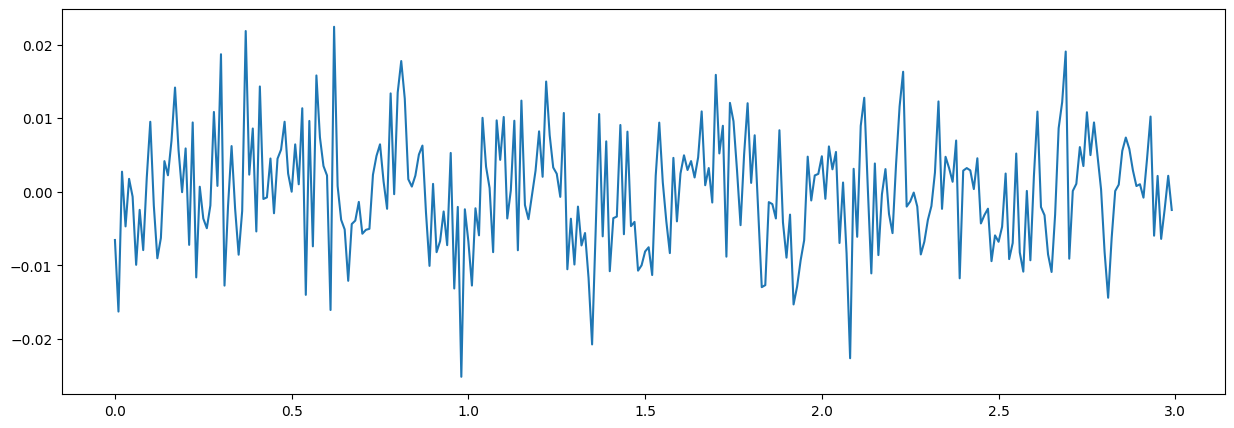

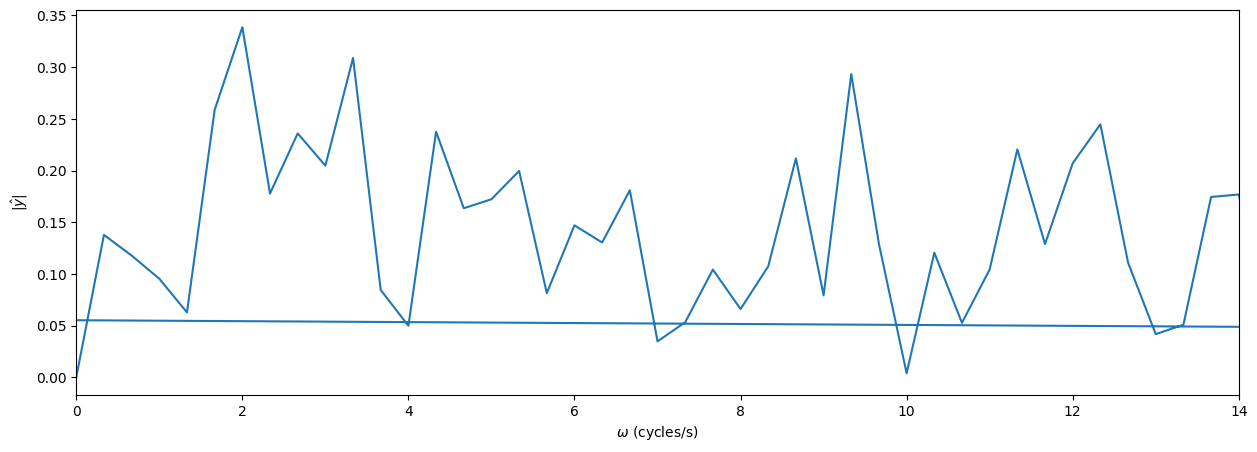

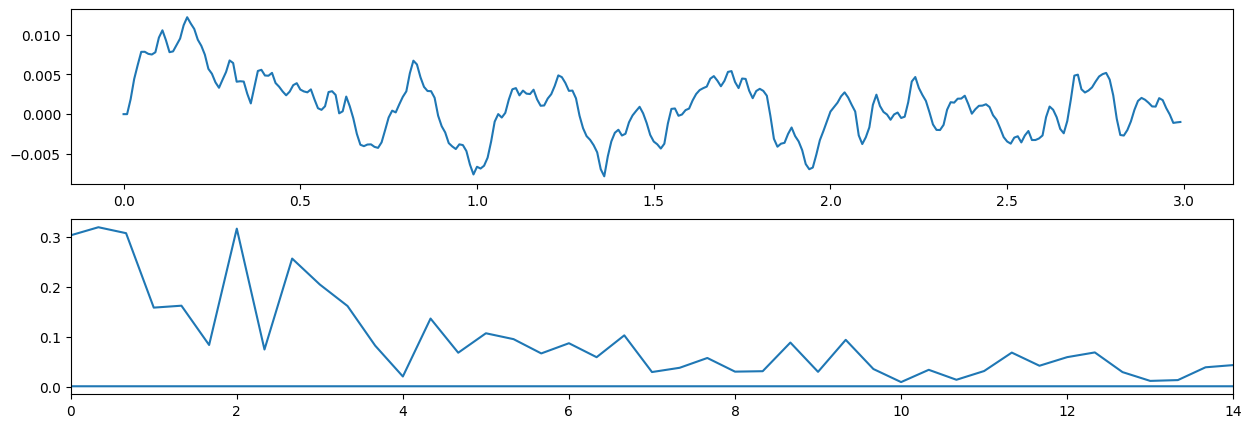

In [ ]:


NSAMPLES=50000
rows = []
with open("values.csv",'r',newline='') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        rows.append(row)

rows = rows[2700:3000]

strings_x = list(pd.DataFrame(rows)[0])
strings_y = list(pd.DataFrame(rows)[1])
strings_z = list(pd.DataFrame(rows)[2])

values = [[eval(strings_x[i]),eval(strings_y[i]),eval(strings_z[i])] for i in range(len(strings_x))]
magnitudes = [np.linalg.norm(values[i]) for i in range(len(strings_z))]

acc_x = [values[i][0]for i in range(len(strings_z))]
acc_y = [values[i][1]for i in range(len(strings_z))]
acc_z = [values[i][2]for i in range(len(strings_z))]

# Compute the Fourier transform of one time series
y = magnitudes-np.mean(magnitudes)
samplingFreq = 100
yhat = np.fft.fft(y)
fcycles = np.fft.fftfreq(len(magnitudes),d=1.0/samplingFreq) # the frequencies in cycles/s
t = [i / samplingFreq for i in range(NSAMPLES)]

# Plot the signal
plt.figure()
plt.plot(t[:len(y)],y)#[len(t)-1500:len(t)]

# Plot the power spectrum
plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.xlim([0,14]);
#plt.ylim([0,15000])
plt.xlabel("$\omega$ (cycles/s)");
plt.ylabel("$|\hat{y}|$");








#HPF
Fc = 0.9
a,b = hpfParams(Fc,Fs)
a = a[1:]    # ignore a[0] --> not relevant

print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a))

# let y now be the high-pass filtered signal
yhpf = applyFilter(y,b,a)


#LPF
Fc = 3.6

a,b = lpfParams(Fc,Fs)
a = a[1:]    # ignore a[0] --> not relevant

print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a))

# let y be the low-pass filtered signal
ylpf = applyFilter(yhpf,b,a)
# compute the Fourier transform --> transform to frequency domain
yhat = np.fft.fft(ylpf)

fcycles = np.fft.fftfreq(len(y),d=1.0/samplingFreq) # the frequencies in cycles/s
t = [i / samplingFreq for i in range(NSAMPLES)]

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(t[:len(ylpf)], ylpf)
ax[1].plot(fcycles, np.absolute(yhat))
plt.xlim([0,14]);

1.0448716361288353
Filter coefficients b_i: [ 0.97250312 -0.97250312]
Filter coefficients a_i: [0.94500624]
Filter coefficients b_i: [0.10160597 0.10160597]
Filter coefficients a_i: [0.79678806]


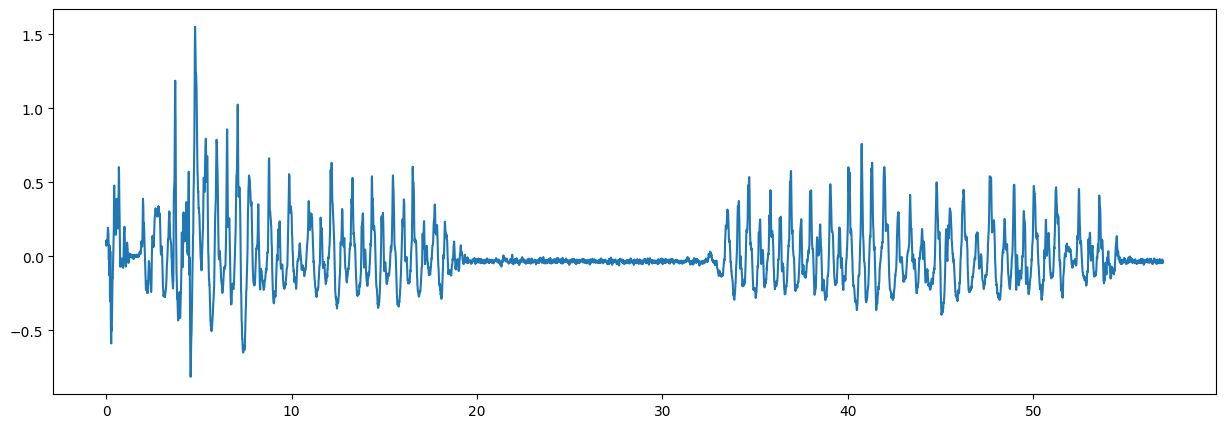

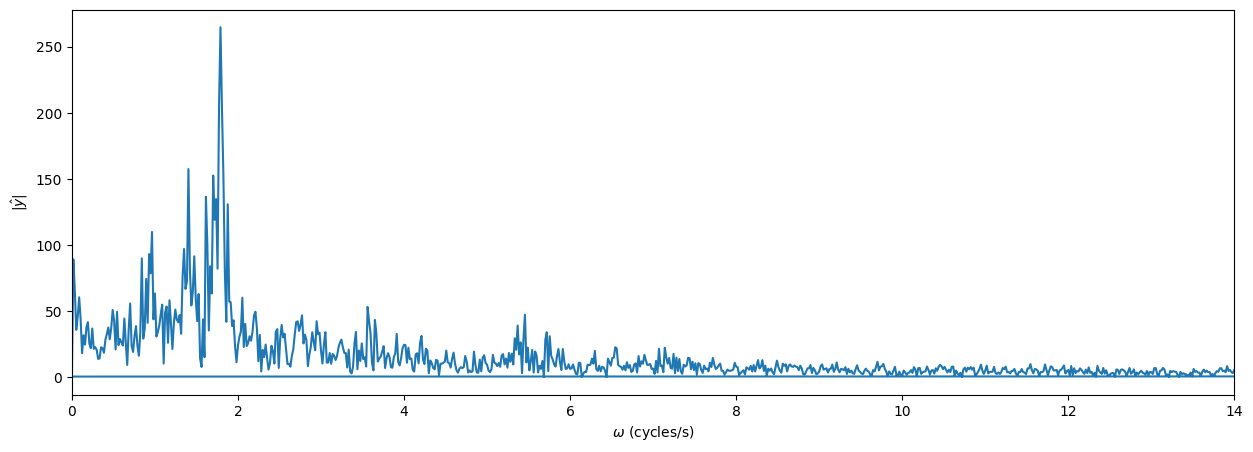

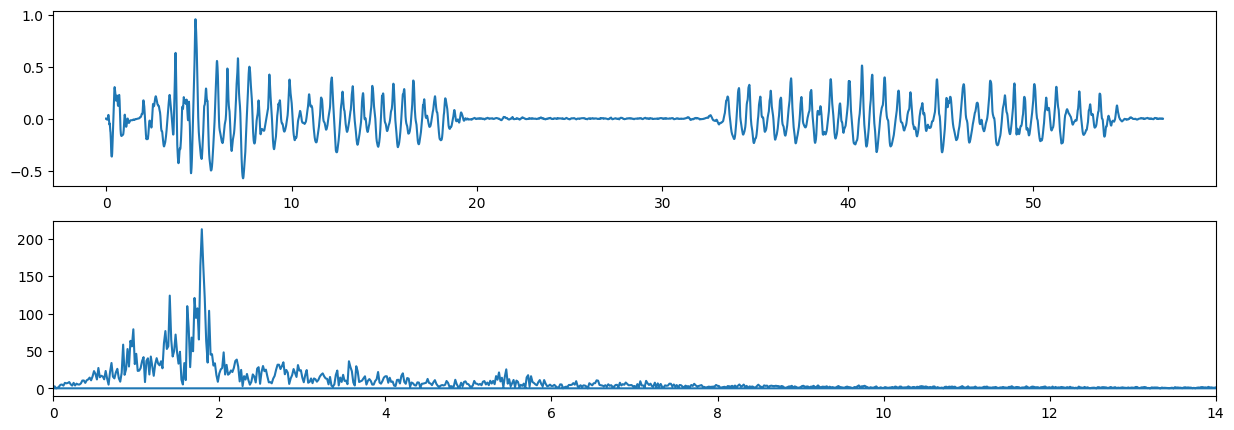

In [ ]:


NSAMPLES=50000
rows = []
with open("values.csv",'r',newline='') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        rows.append(row)

rows = rows[300:6000]

strings_x = list(pd.DataFrame(rows)[0])
strings_y = list(pd.DataFrame(rows)[1])
strings_z = list(pd.DataFrame(rows)[2])

values = [[eval(strings_x[i]),eval(strings_y[i]),eval(strings_z[i])] for i in range(len(strings_x))]
magnitudes = [np.linalg.norm(values[i]) for i in range(len(strings_z))]

acc_x = [values[i][0]for i in range(len(strings_z))]
acc_y = [values[i][1]for i in range(len(strings_z))]
acc_z = [values[i][2]for i in range(len(strings_z))]

# Compute the Fourier transform of one time series
y = magnitudes-np.mean(magnitudes)
print(np.mean(magnitudes))
samplingFreq = 100
yhat = np.fft.fft(y)
fcycles = np.fft.fftfreq(len(magnitudes),d=1.0/samplingFreq) # the frequencies in cycles/s
t = [i / samplingFreq for i in range(NSAMPLES)]

# Plot the signal
plt.figure()
plt.plot(t[:len(y)],y)#[len(t)-1500:len(t)]

# Plot the power spectrum
plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.xlim([0,14]);
#plt.ylim([0,15000])
plt.xlabel("$\omega$ (cycles/s)");
plt.ylabel("$|\hat{y}|$");








#HPF
Fc = 0.9
a,b = hpfParams(Fc,Fs)
a = a[1:]    # ignore a[0] --> not relevant

print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a))

# let y now be the high-pass filtered signal
yhpf = applyFilter(y,b,a)


#LPF
Fc = 3.6

a,b = lpfParams(Fc,Fs)
a = a[1:]    # ignore a[0] --> not relevant

print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a))

# let y be the low-pass filtered signal
ylpf = applyFilter(yhpf,b,a)
# compute the Fourier transform --> transform to frequency domain
yhat = np.fft.fft(ylpf)

fcycles = np.fft.fftfreq(len(y),d=1.0/samplingFreq) # the frequencies in cycles/s
t = [i / samplingFreq for i in range(NSAMPLES)]

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(t[:len(ylpf)], ylpf)
ax[1].plot(fcycles, np.absolute(yhat))
plt.xlim([0,14]);